In [ ]:
#Install dependencies
!pip install -q transformers datasets evaluate peft accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/491.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 481.3/491.2 kB 27.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/84.0 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/116.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/

In [ ]:
import os
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from google.colab import files

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#Upload test_unlabelled.pkl
uploaded = files.upload()
test_pkl_name = list(uploaded.keys())[0]

Saving test_unlabelled.pkl to test_unlabelled.pkl


In [ ]:
#Load train dataset (AGNews only, rule compliant)
dataset = load_dataset("ag_news")
train_df = dataset["train"].to_pandas()
train_df = train_df.rename(columns={"text": "description"})
train_df["title"] = ""
train_df["text"] = train_df["title"].fillna("") + ". " + train_df["description"].fillna("")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
#Load test dataset from provided pickle
test_df = pd.read_pickle(test_pkl_name)
if hasattr(test_df, "to_pandas"):
    test_df = test_df.to_pandas()
if "description" not in test_df.columns:
    test_df["description"] = test_df["text"] if "text" in test_df.columns else ""
if "title" not in test_df.columns:
    test_df["title"] = ""
test_df["text"] = test_df["title"].fillna("") + ". " + test_df["description"].fillna("")

In [ ]:
#Tokenize
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text", "label"]]).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df[["text"]]).map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"]).with_format("torch")
test_dataset = test_dataset.remove_columns(["text"]).with_format("torch")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
#LoRA-adapted RoBERTa
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
for p in model.base_model.parameters():
    p.requires_grad = False

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, config)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 888580


In [ ]:
#Trainer setup
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy.compute(predictions=preds, references=labels)}

args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    fp16=True,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    label_smoothing_factor=0.0,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset = train_dataset.shuffle(seed=42),
    eval_dataset=train_dataset.shuffle(seed=42).select(range(2000)),
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-10-c593de2d5ee1>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
500,0.731900
1000,0.293000
1500,0.275300
2000,0.273800
2500,0.261900
3000,0.251300
3500,0.255300
4000,0.243300
4500,0.244100
5000,0.241000


TrainOutput(global_step=9375, training_loss=0.27213731201171876, metrics={'train_runtime': 2524.4767, 'train_samples_per_second': 237.673, 'train_steps_per_second': 3.714, 'total_flos': 3.98768246784e+16, 'train_loss': 0.27213731201171876, 'epoch': 5.0})

In [ ]:

#Predict
preds = trainer.predict(test_dataset)

if preds.predictions.ndim == 2:
    labels = np.argmax(preds.predictions, axis=-1)
else:
    labels = preds.predictions.astype(int)

#Create submission with correct headers: "ID", "Label"
submission = pd.DataFrame({
    "ID": test_df["id"] if "id" in test_df.columns else np.arange(len(labels)),
    "Label": labels.astype(int)
})

submission.to_csv("submission.csv", index=False, encoding="utf-8")

from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Parameters: 125537288
Trainable Parameters: 888580


Trainer is attempting to log a value of "{'accuracy': 0.9225}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.



Final Evaluation Metrics:
Metric                              Value
--------------------------------------------------
eval_loss                           0.2365
eval_accuracy.accuracy              0.9225
eval_runtime                        3.4045
eval_samples_per_second             587.4650
eval_steps_per_second               18.5050
epoch                               5.0000


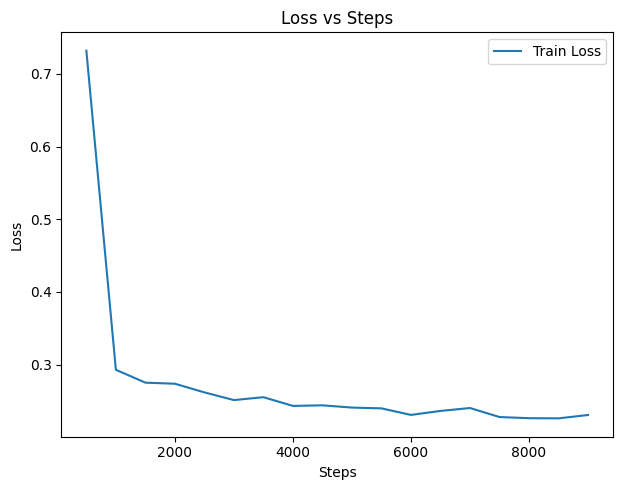

In [ ]:
import matplotlib.pyplot as plt

# Extract step-wise logs
logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "step" in log and "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

eval_steps = [log["step"] for log in logs if "step" in log and "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

# Log parameter counts
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

def print_evaluation_metrics(metrics: dict):
    print("\nFinal Evaluation Metrics:")
    print(f"{'Metric':<35} {'Value'}")
    print("-" * 50)

    for key, value in metrics.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                full_key = f"{key}.{sub_key}"
                print(f"{full_key:<35} {sub_value:.4f}")
        elif isinstance(value, float):
            print(f"{key:<35} {value:.4f}")
        else:
            print(f"{key:<35} {value}")


final_eval = trainer.evaluate()
print_evaluation_metrics(final_eval)

#Plotting
plt.figure(figsize=(12, 5))

#Loss plot
plt.subplot(1, 2, 1)
if train_steps and train_loss:
    plt.plot(train_steps, train_loss, label="Train Loss")
plt.title("Loss vs Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()